Copyright © 2024 Xiaohan Dan(xiaohan.dan@yale.edu), Saurabh Baswaraj Shivpuje(sshivpuj@purdue.edu), Yuchen Wang(wang3602@purdue.edu)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Tutorial on quantum algorithm with the Lindblad Master Equation

Here, we provide the code for a general quantum algorithm simulating open quantum dynamics described by the Kraus operators on IBM quantum simulator QASM. This code allows you to choose your Kraus operators and initial density matrix, these are the two only input requirement. The example discussed in this code is the amplitude damping model. For detailed explanations, please refer our works: Sci Rep 10, 3301 (2020)https://doi.org/10.1038/s41598-020-60321-x And Quantum 6, 726 (2022)https://doi.org/10.22331/q-2022-05-30-726. The python and IBM qiskit codes of algorithm involved in implementing the Kraus operators are included in the following order:   

1. Importing libraries
2. Accepting inputs
3. 2-dilation function
4. QASM simulation
5. Plotting the simulation results


# Importing Libraries
The four major libraries imported for this code are:
* "numpy" for all matrix related numerical calculations
* "scipy" for calculating square root of matrix
* "matplotlib" for generating plots from results obtained
* "qiskit" for all types of quantum implementation

In [1]:
!pip install qiskit==1.0.2
!pip install qiskit_aer==0.14.0.1
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 17.3 MB/s eta 0:00:00


# Simulating the Lindblad Master Equation on Digital Computers

## Definition of Matrix Exponential Propagation and QuTiP solver

In [2]:
import numpy as np
import scipy.linalg as LA
"""
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - rho0: Initial density matrix (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators (numpy array of shape (N, N)).
    - observable: Observable for which the expectation value is computed (numpy array of shape (N, N)).
    - IsGt: Boolean variable that determines whether to output the propagator list
    - Is_store_state: Boolean variable that determines whether to output the density matrix list
    - show_step: Boolean variable that determines whether to print the current step during simulation
    Returns:
    - result: A class containing all the results
      result.expect: List of expectation values of the observable over time.
      result.G_prop: List of propagators.
      result.density_matrix: List of density matrices.
    """
def matrix_expo_prop(H, rho0, time_arr, L, observable, IsGt = False, Is_store_state = False, Is_show_step = False):
    Nsys = H.shape[0]
    ident_h = np.eye(Nsys, dtype=np.complex_)

    class Result:
      def __init__(self):
        self.expect = []
        if(IsGt):
          self.G_prop = []
        if(Is_store_state):
          self.density_matrix = []
    result = Result()

    # Amatrix for time-derivation of the vectorized density matrix
    Amat = -1j * (np.kron(H, ident_h) - np.kron(ident_h, H.T))
    for i in range(len(L)):
      Amat += 0.5 * (2.0 * (np.kron(L[i], L[i].conj()))
                           - np.kron(ident_h, L[i].T @ L[i].conj())
                           - np.kron(L[i].T.conj() @ L[i], ident_h))

    vec_rho0 = rho0.reshape(Nsys**2)

    for t in time_arr:
        if(Is_show_step): print(t)
        Gt = LA.expm(Amat * t)
        if(IsGt): result.G_prop.append(Gt)

        vec_rhot = Gt @ vec_rho0
        rhot = vec_rhot.reshape(Nsys, Nsys)
        if(Is_store_state):  result.density_matrix.append(rhot)
        result.expect.append(np.trace(rhot @ observable).real)

    return result

In [3]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect


## The Spin-1/2 system

In [4]:
# Pauli matrices
sigmax = np.array([[0, 1], [1, 0]], dtype=np.complex_)
sigmaz = np.array([[1, 0], [0, -1]], dtype=np.complex_)
sigmay = np.array([[0, -1j], [1j, 0]], dtype=np.complex_)
ident = np.eye(2, dtype=np.complex_)

# Spin-up and spin-down states
spin_up = np.array([1.0, 0.0], dtype=np.float_)
spin_down = np.array([0.0, 1.0], dtype=np.float_)

# The Spin-1/2 system Hamiltonian
H_1spin = 2 * np.pi * 0.1 * sigmax

# The jump operator and damping rate of Spin-1/2 system
gamma_1spin = 0.05
L_1spin = np.sqrt(gamma_1spin)*sigmax.copy()

# Initial density matrix
rho0_1spin = np.outer(spin_up, spin_up.conj())

# Time step and number of steps
dt = 0.1
nsteps = 250
time_arr = np.linspace(0, (nsteps - 1) * dt, nsteps)

# Matrix Exponential Propagation
result_matrix_exp = matrix_expo_prop(H_1spin, rho0_1spin, time_arr, [L_1spin], sigmaz)

# QuTiP Propagation for Liouville equation (no collapse operator)
expec_vals_qutip_Liouv = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [], Qobj(sigmaz))

# QuTiP Propagation for Lindblad equation
expec_vals_qutip_Lindblad = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [Qobj(L_1spin)], Qobj(sigmaz))

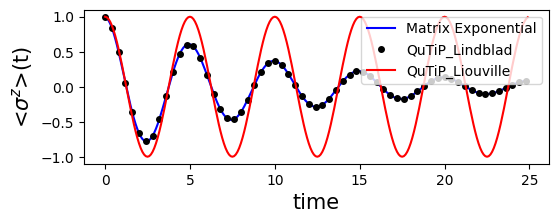

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,2))
plt.plot(time_arr, result_matrix_exp.expect,'b-', label = "Matrix Exponential")
plt.plot(time_arr, expec_vals_qutip_Lindblad[0],'ko',markersize=4,markevery=4, label = "QuTiP_Lindblad")
plt.plot(time_arr, expec_vals_qutip_Liouv[0],'r-', label = "QuTiP_Liouville")
plt.xlabel('time',fontsize=15)
plt.ylabel('<$\sigma^z$>(t)',fontsize=15)
plt.legend(loc = 'upper right')

##The spin-chain

### The system Hamiltonian and initial state

In [6]:
#the system Hamiltonian parameter
nsite = 3 #this states how many spins in the simulation
Nsys_sc = 2**nsite #this is the dimension of the Hilbert space
Omegai_list = [0.65, 1.0, 1.0]
Jix_list = [0.75, 1.0]
Jiy_list = [0.75, 1.0]
Jiz_list = [0.0, 0.0]

#set up the initial state at [up,down,down...]
init_state = spin_up.copy()
for i in range(nsite-1):
  init_state = np.kron(init_state,spin_down)

#set up the initial density matrix according to initial state
rho0_sc = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
rho0_sc += np.outer(init_state,init_state.conj())

In [7]:
#the diagnoal part of the Hamiltonian
H_diag = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
for n in range(nsite):
    tmp = 1.0
    for i in range(nsite):
      if(i==n):
        tmp = np.kron(tmp,sigmaz)
      else:
        tmp = np.kron(tmp,ident)
    H_diag += Omegai_list[n]*tmp
#the non-diagnoal (coupling) part of the Hamiltonian
H_coup = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
XX = np.kron(sigmax,sigmax)
YY = np.kron(sigmay,sigmay)
ZZ = np.kron(sigmaz,sigmaz)
for n in range(nsite-1):
  coup_tmp = Jix_list[n]*XX+Jiy_list[n]*YY+Jiz_list[n]*ZZ
  tmp = 1.0
  for i in range(nsite-1):
    if(n==i):
      tmp = np.kron(tmp,coup_tmp)
    else:
      tmp = np.kron(tmp,ident.copy())
  H_coup += tmp
Hsys_sc = H_diag - 0.5 * H_coup
Hsys_sc_qobj = Qobj(Hsys_sc)

### Setup the Lindbladian

In [8]:
#The lindblad damping rate
Gamma1 = [0.016]*nsite
Gamma2 = [0.0523]*nsite

#The Collapse operators
L_sc = []
L_sc_qobj = [] #this stores Qobj type for QuTiP methods

sigmap = (sigmax+1j*sigmay)*0.5
sigmam = (sigmax-1j*sigmay)*0.5
sigma2 = sigmap@sigmam

for isite in range(nsite):
  #Lindbladian for type 1
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,sigmam)*np.sqrt(Gamma1[isite])
    else:
      res = np.kron(res,ident)
  L_sc.append(res)
  L_sc_qobj.append(Qobj(res))

  #Lindbladian for type 2
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,sigma2)*np.sqrt(Gamma2[isite])
    else:
      res = np.kron(res,ident)
  L_sc.append(res)
  L_sc_qobj.append(Qobj(res))

### Spin-chain Dynamics: Matrix Exponential Propagation and QuTiP solver

In [9]:
# Matrix Exponential Propagation
result_matrix_exp = matrix_expo_prop(Hsys_sc, rho0_sc, time_arr, L_sc, rho0_sc, IsGt=True)

rho0_sc_qobj = Qobj(rho0_sc)
# QuTiP Propagation for Liouville equation (no collapse operator)
result_qutip_Liouv = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, [], rho0_sc_qobj)

# QuTiP Propagation for Lindblad equation
result_qutip_Lindblad = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, L_sc_qobj, rho0_sc_qobj)

As_matrix_exp = np.sqrt(result_matrix_exp.expect[:])
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])

Gprop_sc = result_matrix_exp.G_prop

### Plot the Spin-chain dynamics

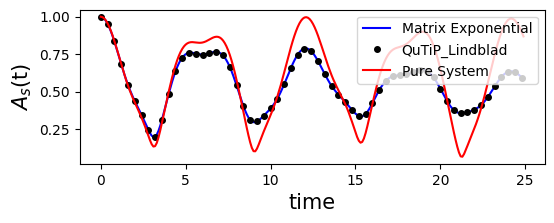

In [10]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_matrix_exp,'b-', label="Matrix Exponential")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP_Lindblad")
plt.plot(time_arr,As_qutip_liouv,'r-',label="Pure System")
plt.xlabel('time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Double Well

###Setup the double-well potential

In [11]:
def pot_doublewell(x, f=0.0367493, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/1.9592
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

In [12]:
#some parameter to convert the units
au2fs   = 2.418884254E-2
au2cm   = 219474.63068
au2joule = 4.35974381E-18
bolz   = 1.3806503E-23
au2ev   = 27.2114
hbar = 1.0

mass0 = 1836.15
beta = au2joule/(bolz*300)
omega = 0.00436 #the frequency associate with the right well
kappa = 1/(10/au2fs)
nth = 1/(np.exp(beta*omega)-1) #0.010264683592287289

#set up the grid point
xmin = -4.0
xmax = 4.0
ndvr = 1024
xgrid = np.linspace(xmin,xmax,ndvr)

pot_arr = pot_doublewell(xgrid)

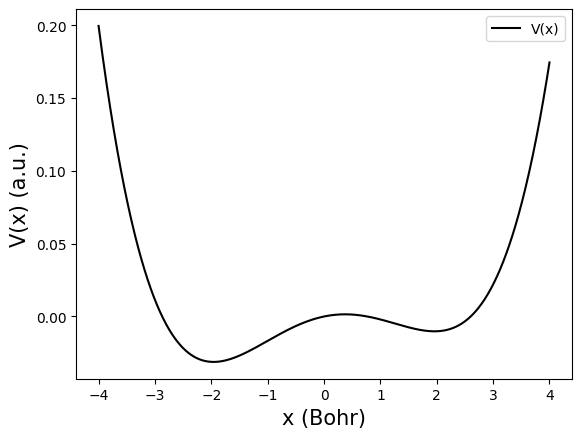

In [13]:
plt.plot(xgrid,pot_arr,'k', label = "V(x)")
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('V(x) (a.u.)',fontsize=15)
plt.legend(loc = 'upper right')

###calculate the eigenstate

In [14]:
import scipy.linalg as LA
#output the eigen state for potential in x-space
#input:kinetic energy hamiltonian, potential in x-space
def eig_state(hamk,pot,xgrid,Nstate):

  Mata = hamk.copy()
  for i in range(ndvr):
    Mata[i,i]+=pot[i]

  val,arr = LA.eigh(Mata)
  dx = xgrid[1]-xgrid[0]
  return val[:Nstate],arr[:,:Nstate]/dx**0.5

In [15]:
import scipy.fft as sfft
kgrid = np.zeros(ndvr,dtype=np.float64)
#ak2: kinetic energy array in k-space
ak2   = np.zeros(ndvr,dtype=np.float64)

dx = xgrid[1]-xgrid[0]
dk = 2.0*np.pi/((ndvr)*dx)
coef_k = hbar**2/(2.0*mass0)

for i in range(ndvr):
  if(i<ndvr//2):
    kgrid[i] = i*dk
  else:
    kgrid[i] = -(ndvr-i) * dk

  ak2[i] = coef_k*kgrid[i]**2

akx0 = sfft.ifft(ak2)
#hamk: kinetic hamiltonian Matrix in position x grid space
hamk = np.zeros((ndvr,ndvr),dtype=np.complex128)

for i in range(ndvr):
  for j in range(ndvr):
    if(i<j):
      hamk[i,j] = akx0[i-j].conj()
    else:
      hamk[i,j] = akx0[i-j]

In [16]:
Neig = 50
eneg_DW,psi_DW = eig_state(hamk,pot_arr,xgrid,Neig)

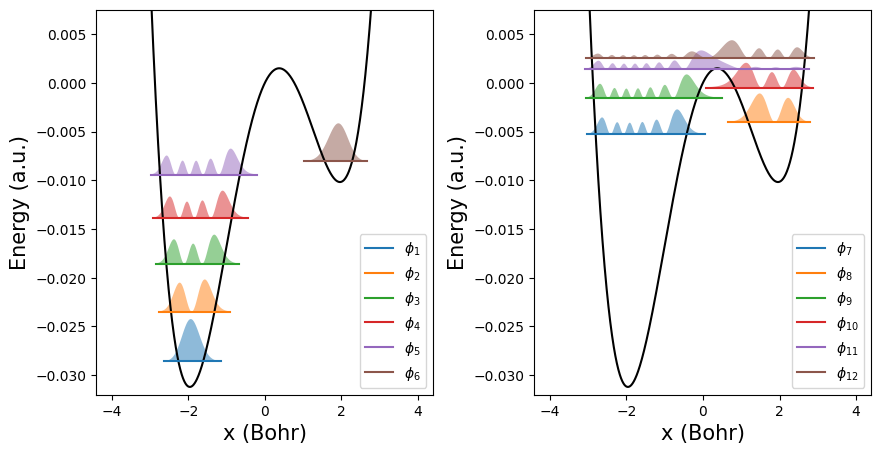

In [17]:
#plot the eigenenergy and the distribution

#distribution
dis = []
for i in range(Neig):
  dis.append(abs(psi_DW[:,i])**2)

x_arr1 = {}
eig_arr1 = {}
dis_plot = {}

for i in range(Neig):
  x_arr1[i]=[]
  eig_arr1[i] = []
  dis_plot[i] = []
  for j in range(len(xgrid)):
    if(abs(dis[i][j])>1E-2):
      x_arr1[i].append(xgrid[j])
      eig_arr1[i].append(eneg_DW[i])
      dis_plot[i].append(dis[i][j])
  dis_plot[i] = np.array(dis_plot[i])

#plot
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(xgrid,pot_arr,'k')

const = 0.0025
for i in range(6):
  plt.plot(x_arr1[i],eig_arr1[i],label=rf'$\phi_{{{i+1}}}$')
  #plt.plot(x_arr1[i],(dis_plot[i]*const+eneg_DW[i]))
  plt.fill_between(x_arr1[i], (dis_plot[i]*const+eneg_DW[i]), eig_arr1[i],alpha=0.5)
plt.ylim((-0.032, 0.0075))
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('Energy (a.u.)',fontsize=15)
plt.legend(loc = 'lower right')

plt.subplot(122)
plt.plot(xgrid,pot_arr,'k')
for i in range(6,12):
  #plt.plot(x_arr1[i],(dis_plot[i]*const+eneg_DW[i]))
  plt.plot(x_arr1[i],eig_arr1[i],label=rf'$\phi_{{{i+1}}}$')
  plt.fill_between(x_arr1[i], (dis_plot[i]*const+eneg_DW[i]), eig_arr1[i],alpha=0.5)

plt.subplots_adjust(wspace=0.3)
plt.ylim((-0.032, 0.0075))
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('Energy (a.u.)',fontsize=15)
plt.legend(loc = 'lower right')

###Express the operators in terms of eigenstate basis


In [18]:
#the eigenstate in the k-space representation
#(by Fourier transform of the original eigenstate in x-space)
psik_DW = np.zeros((ndvr,Neig),dtype=np.complex_)
pre_fac = dx/(2*np.pi)**0.5
for i in range(Neig):
  psik_DW[:,i] = sfft.fft(psi_DW[:,i])*pre_fac

#initial density matrix
ini_occu = np.zeros(Neig,dtype=np.complex_)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

#The operator in the eigenstate
xmat_eig = np.zeros((Neig,Neig),dtype=np.complex_)
pmat_eig = np.zeros((Neig,Neig),dtype=np.complex_)
for i in range(Neig):
  for j in range(Neig):
    xmat_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),xgrid),psi_DW[:,j])*dx
    pmat_eig[i,j] = np.dot(np.multiply(psik_DW[:,i].conj(),kgrid),psik_DW[:,j])*dk

#hamiltonian
H_dw = np.diag(eneg_DW)
#creation/annihilation operator
amat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)+1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)
adegmat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)-1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)

In [19]:
#define the population on the left/right well
x_barrier = 0.37321768
P_R = np.heaviside(xgrid-x_barrier,1)
P_L = 1 - np.heaviside(xgrid-x_barrier,1)

P_R_eig = np.zeros((Neig,Neig),dtype=np.complex_)
P_L_eig = np.zeros((Neig,Neig),dtype=np.complex_)
for i in range(Neig):
  for j in range(Neig):
    P_R_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_R),psi_DW[:,j])*dx
    P_L_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_L),psi_DW[:,j])*dx

###Propogate the dynamics

In [21]:
#propogate using QuTiP
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))
time_qtp = np.linspace(0,1000/au2fs,20000)

#run the dynamics with different eigenstates truncation
result_qtp = {}
for N_eig_use in [20,30,40]:
  c_ops = [gamma1*Qobj(amat_eig[:N_eig_use,:N_eig_use]), gamma2*Qobj(adegmat_eig[:N_eig_use,:N_eig_use])]
  obs = [Qobj(P_R_eig[:N_eig_use,:N_eig_use]), Qobj(P_L_eig[:N_eig_use,:N_eig_use])]
  result_qtp[N_eig_use] = mesolve(Qobj(H_dw[:N_eig_use,:N_eig_use]), Qobj(rho0[:N_eig_use,:N_eig_use]), time_qtp, c_ops, obs, progress_bar=True)

/usr/local/lib/python3.10/dist-packages/qutip/solver/solver_base.py:459: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


10.0%. Run time:   0.60s. Est. time left: 00:00:00:05
20.0%. Run time:   1.19s. Est. time left: 00:00:00:04
30.0%. Run time:   1.79s. Est. time left: 00:00:00:04
40.0%. Run time:   2.37s. Est. time left: 00:00:00:03
50.0%. Run time:   2.91s. Est. time left: 00:00:00:02
60.0%. Run time:   3.50s. Est. time left: 00:00:00:02
70.0%. Run time:   4.01s. Est. time left: 00:00:00:01
80.0%. Run time:   4.57s. Est. time left: 00:00:00:01
90.0%. Run time:   6.59s. Est. time left: 00:00:00:00
100.0%. Run time:   8.74s. Est. time left: 00:00:00:00
Total run time:   8.75s
10.0%. Run time:   1.79s. Est. time left: 00:00:00:16
20.0%. Run time:   3.68s. Est. time left: 00:00:00:14
30.0%. Run time:   5.44s. Est. time left: 00:00:00:12
40.0%. Run time:   7.04s. Est. time left: 00:00:00:10
50.0%. Run time:   8.77s. Est. time left: 00:00:00:08
60.0%. Run time:  13.34s. Est. time left: 00:00:00:08
70.0%. Run time:  14.79s. Est. time left: 00:00:00:06
80.0%. Run time:  16.33s. Est. time left: 00:00:00:04
90.

In [ ]:
#propagation using matrix exponential propagation
N_eig_use=30
c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
observable = P_R_eig[:N_eig_use,:N_eig_use]

time_short = np.linspace(0,1000/au2fs,30) #compare to QuTiP time scale
result_s = matrix_expo_prop(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use], time_short, c_ops, observable, Is_show_step=True)

time_long = np.linspace(0,20000/au2fs,60) #long time propagation
result_dw_l = matrix_expo_prop(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use], time_long, c_ops, observable, IsGt = True, Is_store_state = True, Is_show_step=True)

0.0
1425.5646405431376
2851.129281086275
4276.693921629412
5702.25856217255
7127.823202715688
8553.387843258824
9978.952483801962
11404.5171243451
12830.081764888238
14255.646405431376
15681.211045974513
17106.77568651765
18532.34032706079
19957.904967603925
21383.469608147065
22809.0342486902
24234.598889233337
25660.163529776477
27085.728170319613
28511.292810862753
29936.85745140589
31362.422091949025
32787.986732492165
34213.5513730353
35639.11601357844
37064.68065412158
38490.24529466472
39915.80993520785
41341.37457575099
0.0
14014.02527991559
28028.05055983118
42042.07583974677
56056.10111966236
70070.12639957794
84084.15167949355
98098.17695940913
112112.20223932472
126126.2275192403
140140.2527991559
154154.2780790715
168168.3033589871
182182.32863890266
196196.35391881826
210210.37919873383
224224.40447864943
238238.42975856503
252252.4550384806
266266.4803183962
280280.5055983118
294294.5308782274
308308.556158143
322322.5814380586
336336.6067179742
350350.6319978897
364364.

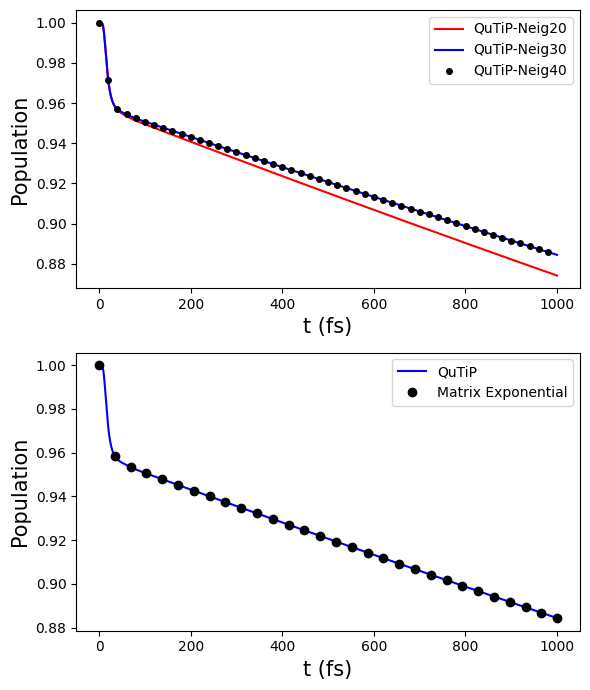

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
axs[0].plot(time_qtp*au2fs,result_qtp[20].expect[0][:],'r-',label = 'QuTiP-Neig20')
axs[0].plot(time_qtp*au2fs,result_qtp[30].expect[0][:],'b-',label = 'QuTiP-Neig30')
axs[0].plot(time_qtp*au2fs,result_qtp[40].expect[0][:],'ko',markersize=4,markevery=400,label = 'QuTiP-Neig40')
axs[0].set_xlabel('t (fs)',fontsize=15)
axs[0].set_ylabel('Population',fontsize=15)
axs[0].legend(loc = 'upper right')

#plt.figure(figsize=(6,3))
axs[1].plot(time_qtp*au2fs,result_qtp[30].expect[0][:],'b-',label = 'QuTiP')
axs[1].plot(time_short*au2fs,result_s.expect[:],'ko',label = 'Matrix Exponential')
axs[1].set_xlabel('t (fs)',fontsize=15)
axs[1].set_ylabel('Population',fontsize=15)
axs[1].legend(loc = 'upper right')

plt.tight_layout()

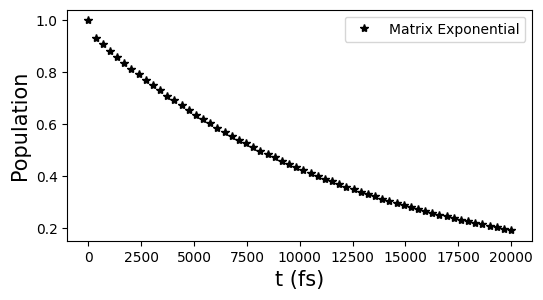

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(time_long*au2fs,result_dw_l.expect,'k*',label = 'Matrix Exponential')
plt.xlabel('t (fs)',fontsize=15)
plt.ylabel('Population',fontsize=15)
plt.legend(loc = 'upper right')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


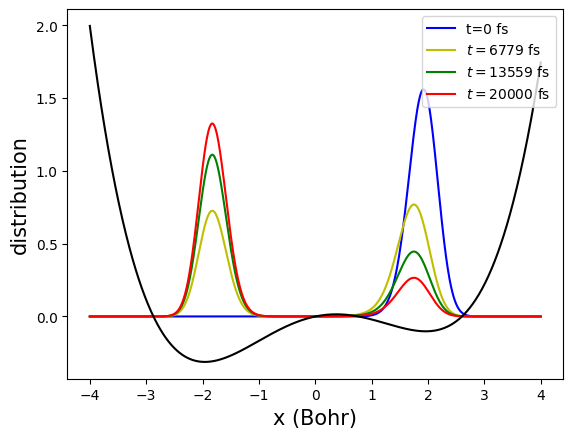

In [ ]:
#extract the distribution
dis_list = []
for nn in [0,20,40,59]:
  rho = result_dw_l.density_matrix[nn]
  rho_grid = np.matmul(np.matmul(psi_DW[:,:N_eig_use],rho),psi_DW[:,:N_eig_use].conj().T)
  dis_list.append(rho_grid.diagonal())

#plot
plt.plot(xgrid,dis_list[0],'b',label='t=0 fs')
plt.plot(xgrid,dis_list[1],'y',label=rf'$t={{{int(time_long[20]*au2fs)}}}$ fs')
plt.plot(xgrid,dis_list[2],'g',label=rf'$t={{{int(time_long[40]*au2fs)}}}$ fs')
plt.plot(xgrid,dis_list[3],'r',label=rf'$t={{{int(time_long[59]*au2fs)}}}$ fs')
plt.plot(xgrid,pot_arr*10,'k')
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('distribution',fontsize=15)
plt.legend(loc = 'upper right')

# Simulating the Lindblad Master Equation on Quantum Computers

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

dilation

In [ ]:
def dilate(array,Isscale=True):

  if(Isscale):
    # Normalization factor, 1.1 times martix's norm to ensure contraction
    norm = LA.norm(array,2)*1.1
    array_new = array/norm
  else:
    array_new = array

  ident = np.eye(array.shape[0])

  # Calculate the conjugate transpose of the G propagator
  fcon = (array_new.conjugate()).T

  # Calculate the defect matrix for dilation
  fdef = LA.sqrtm(ident - np.dot(fcon, array_new))

  # Calculate the defect matrix for the conjugate of the G propagator
  fcondef = LA.sqrtm(ident - np.dot(array_new, fcon))

  # Dilate the G propagator to create a unitary operator
  array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])
  if(Isscale):
    return array_dilated, norm
  else:
    return array_dilated

## The Spin-1/2 system: Amplitude-channel damping

In [ ]:
Nsys_1spin = 2
#defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex_)
vec0_sdam0 = rho0_sdam.reshape(Nsys_1spin**2)
norm0_sdam = LA.norm(vec0_sdam0,2)
vec0_sdam0 /= norm0_sdam
print(norm0_sdam)

In [ ]:
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps
Nsys_1spin = 2

#defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex_)
vec0_sdam = rho0_sdam.reshape(Nsys_1spin**2)
norm0_sdam = LA.norm(vec0_sdam,2)
vec0_sdam /= norm0_sdam

ident_h = np.eye(Nsys_1spin, dtype = np.complex_)
Amat = np.zeros((Nsys_1spin**2,Nsys_1spin**2),dtype=np.complex_)

#matrix for time-derivation of the vectorized density matrix
Amat += 0.5*gamma*(2*(np.kron(sigmap,sigmap.conj())) - np.kron(ident_h, sigmap.T@sigmap.conj()) - np.kron(sigmap.T.conj()@sigmap,ident_h))

Pop_Mexp = np.zeros((2,len(time_sdam)),dtype=np.float_) #population array

Gprop_sdam = []
for i in range(len(time_sdam)):

  Gt = LA.expm(Amat*time_sdam[i])
  Gprop_sdam.append(Gt)

  rhot_sdam = (Gt@vec0_sdam).reshape(Nsys_1spin,Nsys_1spin)*norm0_sdam
  Pop_Mexp[0,i] = rhot_sdam[0,0].real
  Pop_Mexp[1,i] = rhot_sdam[1,1].real

In [ ]:
# initial state in the dilated space
rho0_sdam_dil = np.concatenate((vec0_sdam,np.zeros(Nsys_1spin**2)))

aersim = AerSimulator()
shots = 2000
Pop_qc = np.zeros((2,len(time_sdam)),dtype=np.float_)

for i in range(len(time_sdam)):
    if(i%100==0):print('istep',i)
    qr = QuantumRegister(2+1)  # Create a quantum register
    cr = ClassicalRegister(2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sdam_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sdam[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)
    # Apply the unitary operator to the quantum circuit's qubits and measure
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)

    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    if '011' and '000' in counts1:
      Pop_qc[0,i] = np.sqrt(counts1['000']/shots)*norm*norm0_sdam
      Pop_qc[1,i] = np.sqrt(counts1['011']/shots)*norm*norm0_sdam
    else:
      print(i,'shots=',shots,"no counts for up state")


In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_sdam,Pop_qc[0,:],'r-',label="quantum,|0>")
plt.plot(time_sdam,Pop_Mexp[0,:],'ko',markersize=5,markevery=40,label="benchmark,|0>")
plt.plot(time_sdam,Pop_qc[1,:],'b-',label="quantum,|1>")
plt.plot(time_sdam,Pop_Mexp[1,:],'yo',markersize=5,markevery=40,label="benchmark,|1>")
plt.xlabel('time (ps)',fontsize=15)
plt.ylabel('$P(t)$',fontsize=15)
plt.legend(loc = 'upper right')

## The spin chain

In [ ]:
# initial state of the spin chain in the dilated space
# rho0_sc=|up,down,...><up,down,...|, has defined in the Digital computer simulation part
rho0_sc_dil = np.concatenate((rho0_sc.reshape(Nsys_sc**2),np.zeros(Nsys_sc**2)))

aersim=AerSimulator()
shots_arr = [1000,10000]
As_qc = np.zeros((len(shots_arr),nsteps),dtype=np.float_)

for i in range(nsteps):
    if(i%10==0):print('istep',i)
    qr = QuantumRegister(nsite*2+1)  # Create a quantum register
    cr = ClassicalRegister(nsite*2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sc_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sc[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)

    qc.measure(qr, cr)

    for ishot in range(len(shots_arr)):
        counts1 = aersim.run(qc,shots=shots_arr[ishot]).result().get_counts()
        if '0011011' in counts1:
          survi_amp = np.sqrt(counts1['0011011']/shots_arr[ishot])*norm
          As_qc[ishot,i] = np.sqrt(survi_amp)
        else:
          print(i,'shots=',shots_arr[ishot],"no counts")


In [ ]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_qc[0][:],'r-',label=f"quantum,counts={shots_arr[0]}")
plt.plot(time_arr,As_qc[1][:],'b-',label=f"quantum,counts={shots_arr[1]}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Double Well

In [ ]:
def expand(Gmat_org,Norg,Nexpand):
  Gnew = np.zeros((Nexpand**2,Nexpand**2),dtype=np.complex_)
  for i in range(Norg):
    for j in range(Norg):
      for k in range(Norg):
        for l in range(Norg):
            Gnew[i*Nexpand+j,k*Nexpand+l] = Gmat_org[i*Norg+j,k*Norg+l]
  return Gnew

dim_dw = 32

#extract the propagator from result of classical simulation
Gprop_dw = []
for i in range(len(result_dw_l.G_prop)):
    org_dim = result_dw_l.density_matrix[i].shape[0]
    Gprop_dw.append(expand(result_dw_l.G_prop[i],org_dim,dim_dw))

In [ ]:
def choi_mat(Gmat,N):
  I = np.eye(N)
  C_mat = np.zeros(Gmat.shape,dtype=np.complex_)
  for i in range(N):
    for j in range(N):
      C_matij = np.zeros(Gmat.shape,dtype=np.complex_)
      for k in range(N):
        for l in range(N):
          C_matij[i*N+k,l*N+j] = Gmat[j*N+k,l*N+i]
      C_mat += C_matij
  return C_mat

#generate the Kraus matries with a given tolerance
def gen_Kraus_list(C_mat,N,tol=1E-5):
  Kraus = []
  val,arr = LA.eigh(C_mat)
  for i in range(len(val)):
    if(val[i]>tol):
      Mi = np.sqrt(val[i])*arr[:,i].reshape(N,N)
      Kraus.append(Mi.conj().T)
  return Kraus

In [ ]:
#For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

Kraus_all = {}
for i0 in range(nsteps):

    i = i0*ilarge
    print('istep',i0)

    #get the kraus operators from the propagator
    C0 = choi_mat(Gprop_dw[i],dim_dw)
    Kraus_all[i0] = gen_Kraus_list(C0,dim_dw,tol=1E-2)

istep 0
istep 1
istep 2
istep 3
istep 4
istep 5
istep 6
istep 7
istep 8
istep 9
istep 10
istep 11


In [ ]:
def nested_kronecker_product(pauli_str):
    '''
    Handles Kronecker Products for list (i.e., pauli_str = 'ZZZ' will evaluate Z Z Z).
    Given string 'pauli_str' this evaluates the kronecker product of all elements.
    '''
    import numpy as np
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,complex(0,-1)],[complex(0,1),0]])
    Z = np.array([[1,0],[0,-1]])
    I = Z@Z
    # Define a dictionary with the four Pauli matrices:
    pms = {'I': I,'X': X,'Y': Y,'Z': Z}

    result = 1
    for i in range(len(pauli_str)):
     result = np.kron(result,pms[pauli_str[i]])
    return result

def decompose(Ham_arr, tol=1E-5):
    '''
    Function that decomposes `Ham_arr` into a sum of Pauli strings.
    result: a dictionary with the key is pauli string and the value is coefficient
    '''
    import numpy as np
    import itertools

    pauli_keys = ['I','X','Y','Z'] # Keys of the dictionary

    nqb = int(np.log2(Ham_arr.shape[0])) # Determine the qubits needed

    # Make all possible tensor products of Pauli matrices sigma
    sigma_combinations = list(itertools.product(pauli_keys, repeat=nqb))

    result = {} # Initialize an empty dictionary to the results
    for ii in range(len(sigma_combinations)):
        pauli_str = ''.join(sigma_combinations[ii])

        # Evaluate the Kronecker product of the matrix array
        tmp_p_matrix = nested_kronecker_product(pauli_str)

        # Compute the coefficient for each Pauli string
        a_coeff = (1/(2**nqb)) * np.trace(tmp_p_matrix @ Ham_arr)

        # If the coefficient is non-zero, we want to use it!
        if abs(a_coeff) > tol:
            result[pauli_str] = a_coeff.real

    return result

In [ ]:
Nqb_dw = int(np.log2(dim_dw))+1

# initial state of the double-well in the dilated space
ini_occu = np.zeros(dim_dw,dtype=np.complex_)
ini_occu[5] = 1.0
stat0_dil = np.concatenate((ini_occu,np.zeros(dim_dw)))

In [ ]:
from qiskit.quantum_info import SparsePauliOp

#decompose the dilated space observable into summation of tensor product of pauli matrices
Obs_mat = np.zeros((2*dim_dw,2*dim_dw),dtype=np.complex_)
Obs_mat[:dim_dw,:dim_dw] = P_R_eig[:dim_dw,:dim_dw]
Obs_paulis_dic = decompose(Obs_mat, tol=5E-3)

#Prepare the qiskit observable from the pauli strings of observable matrix
data = []
coef = []
for key in Obs_paulis_dic:
  data.append(key)
  coef.append(Obs_paulis_dic[key])
obs_q = SparsePauliOp(data,coef)

In [ ]:
from qiskit_aer.primitives import Estimator

#Aer implementation of an Estimator
estimator = Estimator()

shots = 2000

#For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

time_dw_qc = np.zeros((nsteps),dtype=np.float_)
P_dw_qc = np.zeros((nsteps),dtype=np.float_)
for i0 in range(nsteps):

    i = i0*ilarge
    print('istep',i0,i)

    time_dw_qc[i0] = time_long[i]

    matKraus_list = Kraus_all[i0]
    print('len',len(matKraus_list))

    for ikraus in range(len(matKraus_list)):

      # Create the quantum circuit
      qr = QuantumRegister(Nqb_dw)
      cr = ClassicalRegister(Nqb_dw)
      qc = QuantumCircuit(qr, cr)

      # Initialize the quantum circuit with the initial state
      qc.initialize(stat0_dil, qr)

      # Create a custom unitary operator with the dilated Kraus propagator
      UM = dilate(matKraus_list[ikraus],Isscale=False)
      UM_op = Operator(UM)

      # Apply the unitary operator to the quantum circuit's qubits
      qc.unitary(UM_op, qr)

      result = estimator.run(qc, obs_q, shots = shots).result()
      P_dw_qc[i0] += result.values[0]


istep 0 0
len 1
istep 1 5
len 78
istep 2 10
len 76
istep 3 15
len 77
istep 4 20
len 76
istep 5 25
len 77
istep 6 30
len 77
istep 7 35
len 75
istep 8 40
len 75
istep 9 45
len 73
istep 10 50
len 76
istep 11 55
len 76


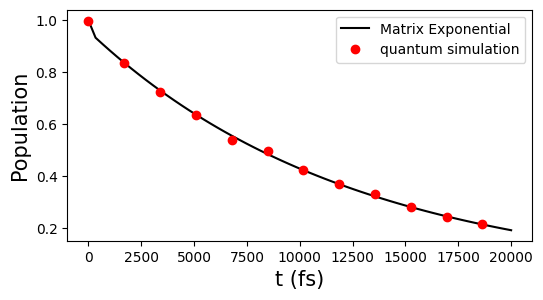

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(time_long*au2fs,result_dw_l.expect,'k-',label = 'Matrix Exponential')
plt.plot(time_dw_qc*au2fs,P_dw_qc,'ro',label = 'quantum simulation')
plt.xlabel('t (fs)',fontsize=15)
plt.ylabel('Population',fontsize=15)
plt.legend(loc = 'upper right')

# Reference: (Yuchen) Simulating amplitude channel damping with Kraus Operators


## Defining the initial state and the Kraus operators

In [ ]:
#defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex_)
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps

iden = np.eye(2)
iden2 = np.eye(4)

#flattening or vectorize the density matrix
rho_norm=LA.norm(rho0_sdam)
rho_flat= rho0_sdam.flatten()/rho_norm

#defining the Kraus operators
def k_0(x):
        k = np.zeros((2,2),'complex')
        k[0,0]=1
        k[0,1]=0
        k[1,0]=0
        k[1,1]= np.sqrt(np.exp(-gamma*x))
        return k
def k_1(x):
        k = np.zeros((2,2),'complex')
        k[0,0]=0
        k[0,1]=np.sqrt(1-np.exp(-gamma*x))
        k[1,0]=0
        k[1,1]=0
        return k

## Defining function for 2-dialation

In [ ]:
#defining the function for dilation
def udil(k):
#first and second stands for the M and N, i.e. Kraus and its complex conjugate
    first= np.kron(k,iden)
    kc=k.conjugate()  #complex conjugate of k
    second= np.kron(iden,kc)
    fcon = (first.conjugate()).T
    scon = (second.conjugate()).T
    #calculate the defect operators of each Kraus operators
    fdef = LA.sqrtm(iden2-np.dot(fcon,first))
    sdef = LA.sqrtm(iden2 -np.dot(scon,second))
    fcondef = LA.sqrtm(iden2-np.dot(first,fcon))
    scondef = LA.sqrtm(iden2-np.dot(second,scon))
    #2-dilation process
    Ufirst= np.block([[first, np.zeros((4,4)),fcondef,np.zeros((4,4))],
    [fdef,np.zeros((4,4)),-fcon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])

    Usecond=np.block([[second, np.zeros((4,4)),scondef,np.zeros((4,4))],
    [sdef,np.zeros((4,4)),-scon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])

    ufre=np.reshape(Ufirst,(1,256))
    usec=np.reshape(Usecond,(1,256))
    #returning the unitaries for both the Kraus operator and its complex conjugate
    return ufre,usec

## QASM simulation with Qiskit package

In [ ]:
#defining lists used to store the results
rho_at_t=np.zeros((1000,2), "complex")
time=np.zeros((1000,1),)
udil01=np.zeros((1000,256),"complex")
udil02=np.zeros((1000,256),"complex")
udil11=np.zeros((1000,256),"complex")
udil12=np.zeros((1000,256),"complex")
# assigning the time-steps
for t in range(0,1000):
    tt=t
    k0=k_0(tt)
    k1=k_1(tt)
    udil01[t],udil02[t] = udil(k0)
    udil11[t],udil12[t] = udil(k1)

shots = 2000
#create dictionaries to store the results. three binary digits due to 8*8 matrix needs three qubits
result = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0}
result2 = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0}
p_excited = []# create list to store probability for acceptor state
p_ground = []# create list to store probability for donor state

# Below are the loop of the QASM simulation
aersim=AerSimulator()
for i in range (0,1000):
    #for Kraus operator 1
    U1first=np.reshape(udil01[i],(16,16))
    U1second=np.reshape(udil02[i],(16,16))
    # qiskit quantum circuit generation process
    initial_state = np.concatenate([rho_flat,np.zeros(12)])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, qr)
    # generating self-defined quantum gates with dilated unitaries
    A = Operator(U1first)
    B = Operator(U1second)
    U_G_op = A.compose(B)
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)
    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    for x in counts1:
        result[x] = counts1[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg1 = np.sqrt(result['0000'] / 2000)*rho_norm
    pe1 =  np.sqrt(result['0011'] / 2000)*rho_norm
    #for Kraus operator 2
    U2first=np.reshape(udil11[i],(16,16))
    U2second=np.reshape(udil12[i],(16,16))
    initial_state2 = np.concatenate([rho_flat,np.zeros(12)])
    qr2 = QuantumRegister(4)
    cr2 = ClassicalRegister(4)
    qc2 = QuantumCircuit(qr2, cr2)
    qc2.initialize(initial_state, qr2)
    C = Operator(U2first)
    D = Operator(U2second)
    U_G_op2 = C.compose(D)
    qc2.unitary(U_G_op2, qr2)
    qc2.measure(qr2, cr2)
    counts2 = aersim.run(qc2, shots=shots).result().get_counts()
    for x in counts2:
        result2[x] = counts2[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg2 = np.sqrt(result2['0000'] / 2000)*rho_norm
    pe2 =  np.sqrt(result2['0011'] / 2000)*rho_norm
    pe=pe1+pe2
    pg=pg1+pg2
    p_excited.append(pe)
    p_ground.append(pg)

## Ploting the simulation results

check the corretness

In [ ]:
#plotting the QASM simulation results
plt.plot(time_sdam, p_ground, 'r-', label="Ground state")
plt.plot(time_sdam, Pop_Mexp[1,:], 'ko', label="Ground state_benchmark")
plt.plot(time_sdam, p_excited, 'b-', label='Excited state')
plt.xlabel('Time (ps)',fontsize=15)
plt.ylabel('P(t)',fontsize=15)
plt.legend(loc = 'upper right')